Examine sensitivity of current best model (Gear-Specific, Multi-Window 
Logistic Model with is-daylight) with respect to the various random
seeds that are used during training.

1. Random seed for model itself. Expect minimal effect

2. Random seed for splitting training / testing data. Perhaps larger effect

As it turns out (see below), neither makes much of a difference. Since this
test was originally convceived the MMSI selection became a lot less random
in order to better match the number of test and training MMSI. As a result,
this lack of sensitivity may not hold as we add new MMSI. That said, we can
expect the results to improve as we add more MMSI going forward.

In [1]:
%matplotlib inline
from vessel_scoring import data, utils
from vessel_scoring.models import train_model_on_data
from vessel_scoring.evaluate_model import evaluate_model, compare_models
from IPython.core.display import display, HTML, Markdown
import numpy as np
import sys
from sklearn import metrics

In [2]:
from vessel_scoring.logistic_model import LogisticModel

def make_model(seed=4321):
    return LogisticModel(colspec=dict(
        windows=[1800, 3600, 10800, 21600, 43200, 86400],
        measures=['measure_daylight', 'measure_speed']), order=6, random_state=seed)


In [3]:
def load_data(seed=4321):
    # Data supplied by Kristina
    _, train_lline,  valid_lline, test_lline = data.load_dataset_by_vessel(
            '../datasets/kristina_longliner.measures.npz', seed)
    _, train_trawl,  valid_trawl, test_trawl = data.load_dataset_by_vessel(
            '../datasets/kristina_trawl.measures.npz', seed)
    _, train_pseine, valid_pseine, test_pseine = data.load_dataset_by_vessel(
            '../datasets/kristina_ps.measures.npz', seed)

    # Slow transits (used to train models to avoid classifying slow transits as fishing)
    TRANSIT_WEIGHT = 10
    x_tran, xtrain_tran, xcross_tran, xtest_tran = data.load_dataset_by_vessel(
                                        '../datasets/slow-transits.measures.npz', even_split=False, seed=seed)
    xtrain_tran = utils.clone_subset(xtrain_tran, test_lline.dtype)
    xcross_tran = utils.clone_subset(xcross_tran, test_lline.dtype)
    xtest_tran = utils.clone_subset(xtest_tran, test_lline.dtype)
    train_tran = np.concatenate([xtrain_tran, xcross_tran] * TRANSIT_WEIGHT)

    train = {'longliner': np.concatenate([train_lline, valid_lline, train_tran]), 
                'trawler': np.concatenate([train_trawl, valid_trawl, train_tran]),
                'purse_seine': np.concatenate([train_pseine, valid_pseine, train_tran])}
    
    test = {'longliner': test_lline, 
            'trawler': test_trawl, 
            'purse_seine': test_pseine}
    
    return train, test

In [4]:
def get_seeds(count):
    np.random.seed(4321)
    return np.random.randint(4294967295, size=count)

First investigate sensitivity of the LogisiticModels to different seeds

Warning, insufficient items to sample, returning all
Warning, inufficient items to sample, returning 4430
Warning, inufficient items to sample, returning 2084


|Model|Recall|Precision|F1-Score|
|-----|------|---------|--------|
|304096061|0.72|0.21|0.33|
|629777570|0.72|0.21|0.33|
|3500673272|0.72|0.21|0.33|
|3188283578|0.72|0.21|0.33|
|3298126716|0.72|0.21|0.33|
|783526034|0.72|0.21|0.33|
|1229883227|0.72|0.21|0.33|
|3270718321|0.72|0.21|0.33|
|829333739|0.72|0.21|0.33|
|3427494695|0.72|0.21|0.33|

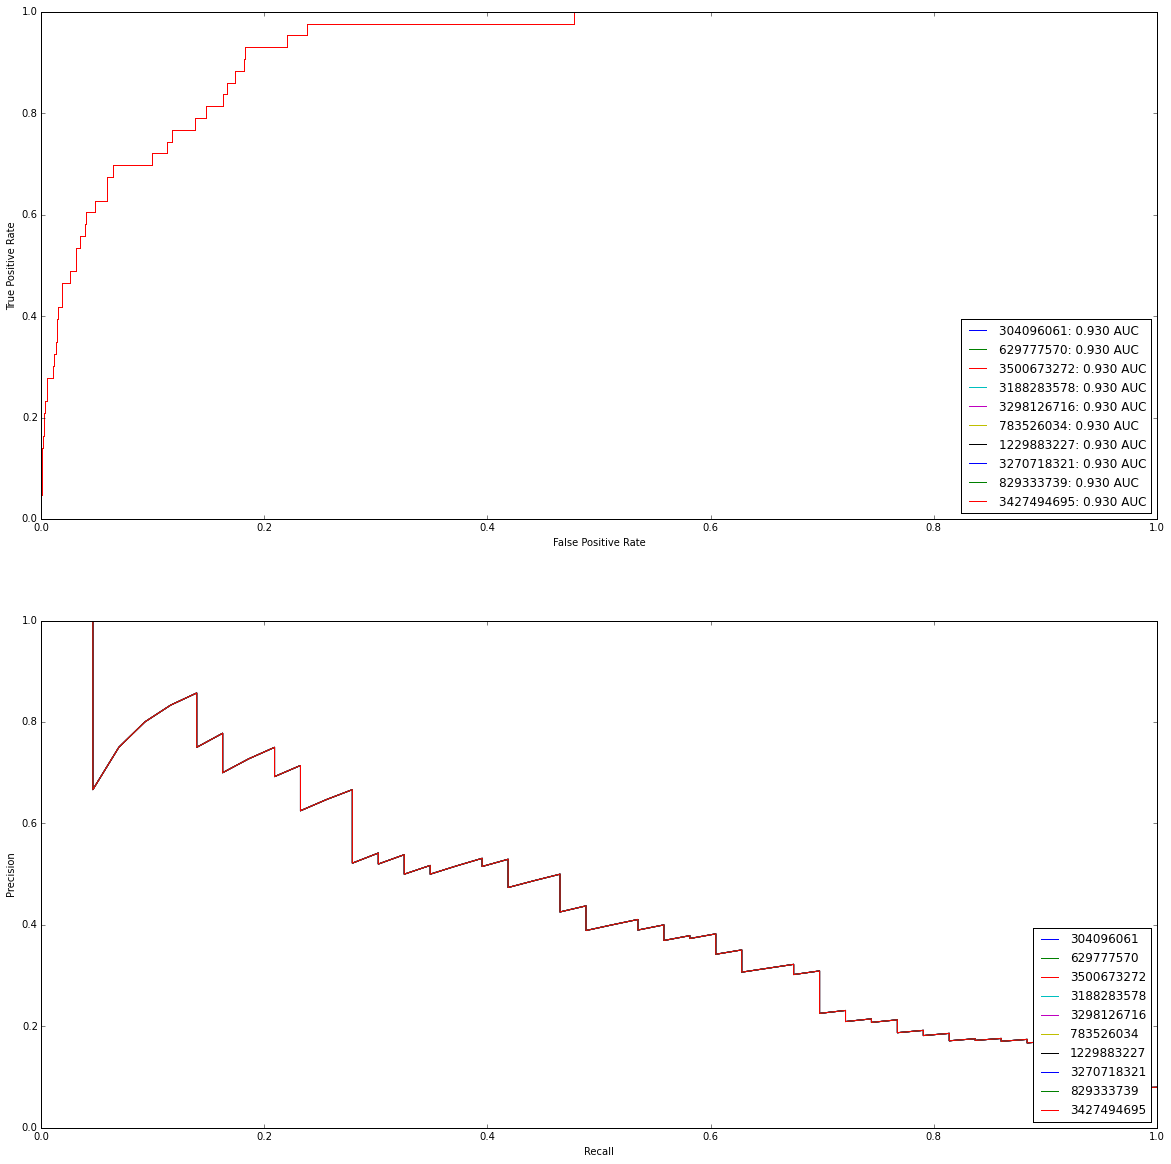

|Model|Recall|Precision|F1-Score|
|-----|------|---------|--------|
|304096061|0.87|0.94|0.90|
|629777570|0.87|0.94|0.90|
|3500673272|0.87|0.94|0.90|
|3188283578|0.87|0.94|0.90|
|3298126716|0.87|0.94|0.90|
|783526034|0.87|0.94|0.90|
|1229883227|0.87|0.94|0.90|
|3270718321|0.87|0.94|0.90|
|829333739|0.87|0.94|0.90|
|3427494695|0.87|0.94|0.90|

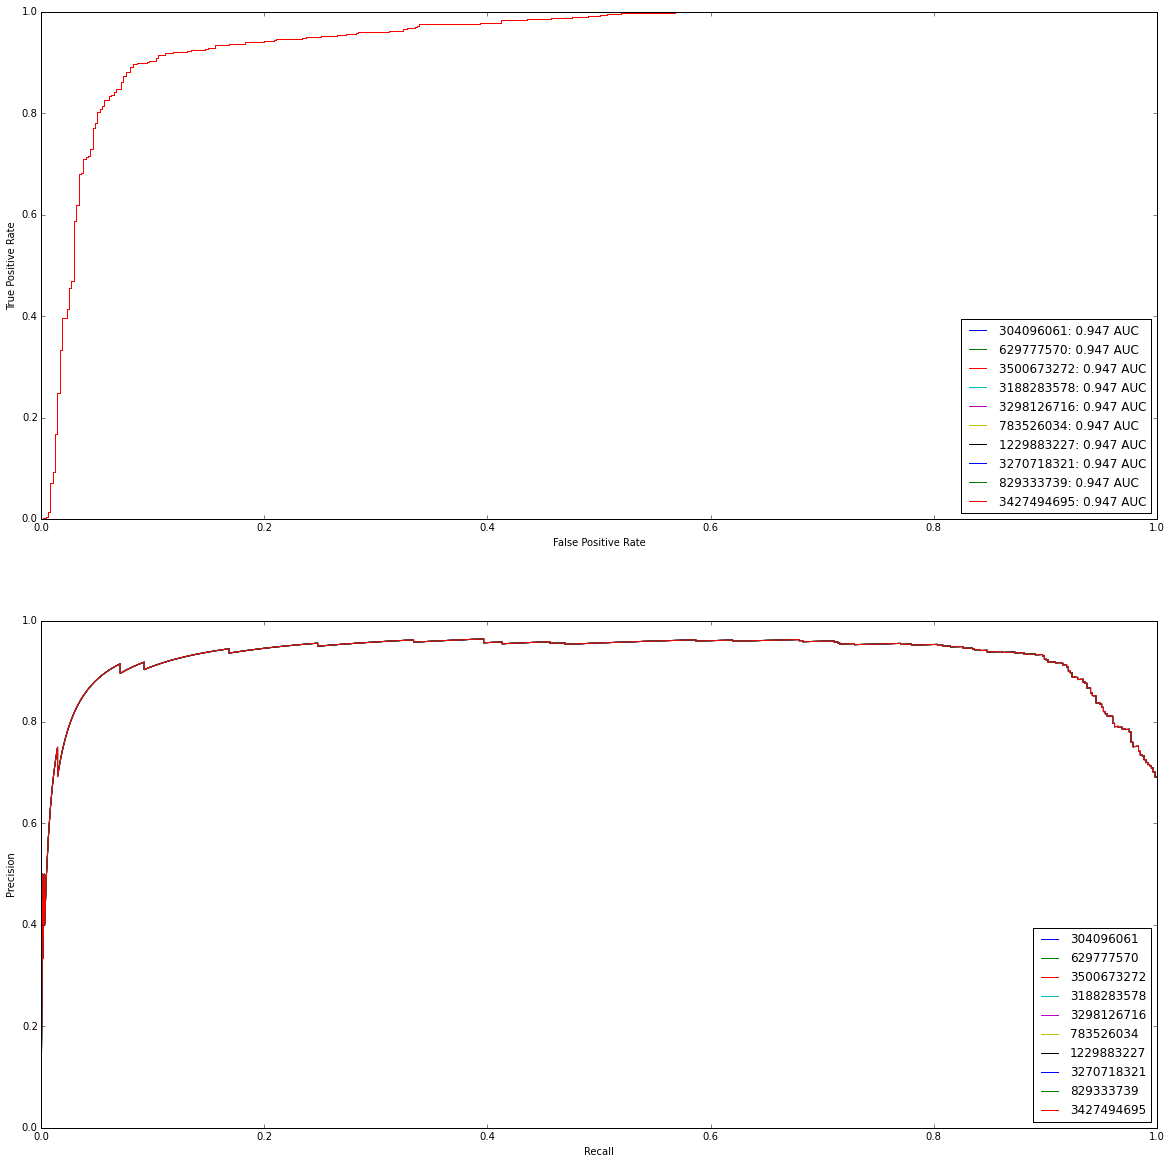

|Model|Recall|Precision|F1-Score|
|-----|------|---------|--------|
|304096061|0.90|0.94|0.92|
|629777570|0.90|0.94|0.92|
|3500673272|0.90|0.94|0.92|
|3188283578|0.90|0.94|0.92|
|3298126716|0.90|0.94|0.92|
|783526034|0.90|0.94|0.92|
|1229883227|0.90|0.94|0.92|
|3270718321|0.90|0.94|0.92|
|829333739|0.90|0.94|0.92|
|3427494695|0.90|0.94|0.92|

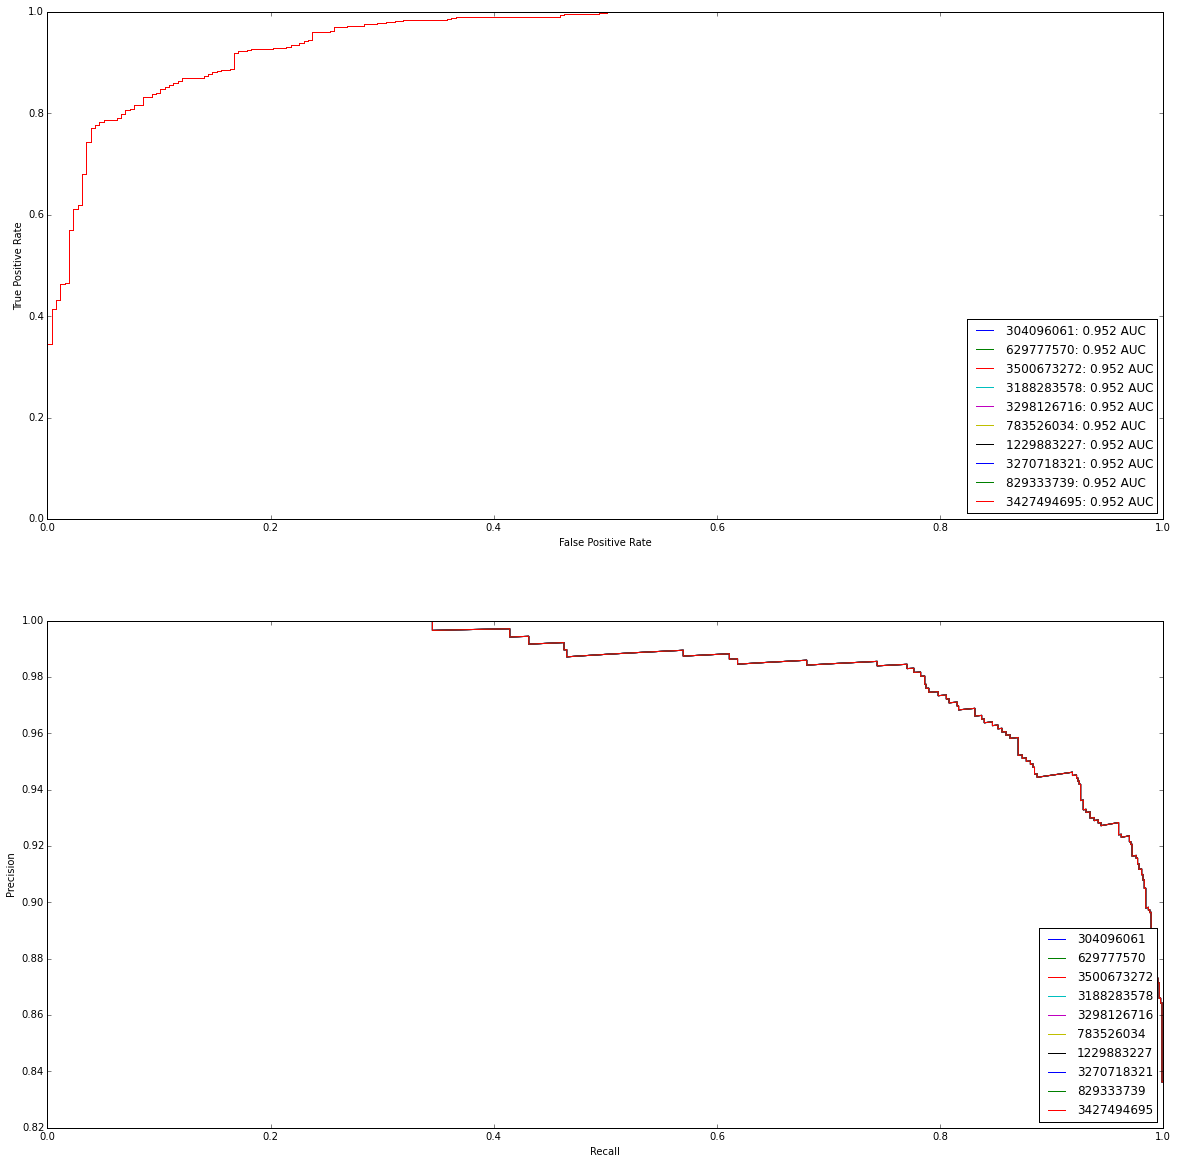

In [5]:
N_SEEDS = 10

train_data, test_data = load_data()

for gear in ['purse_seine', 'trawler', 'longliner']:
    X_test = test_data[gear]

    display(HTML("<h2>{}</h2>".format(gear.replace('_', ' ').title())))
        
    predictions = []
    trained_models = []
    for seed in get_seeds(N_SEEDS):
        mdl = make_model(seed)
        
        train_model_on_data(mdl, train_data[gear])
        
        trained_models.append((seed, mdl))
        
        predictions.append((seed, (mdl.predict_proba(X_test)[:,1] > 0.5), X_test['classification'] > 0.5))

    lines = ["|Model|Recall|Precision|F1-Score|",
         "|-----|------|---------|--------|"]
    for name, pred, actual in predictions:
        lines.append("|{}|{:.2f}|{:.2f}|{:.2f}|".format(name, 
                                            metrics.recall_score(actual, pred),
                                            metrics.precision_score(actual, pred), 
                                            metrics.f1_score(actual, pred)))

    display(Markdown('\n'.join(lines)))

    compare_models(trained_models, X_test)
    
    display(HTML("<hr/>"))

Essentially no difference when setting the seed for different runs.

What about setting the seed when loading the data?

Warning, insufficient items to sample, returning all
Warning, inufficient items to sample, returning fewer
Warning, inufficient items to sample, returning 113468
Warning, insufficient items to sample, returning all
Warning, inufficient items to sample, returning fewer
Warning, inufficient items to sample, returning 186962
Warning, insufficient items to sample, returning all
Warning, inufficient items to sample, returning fewer
Warning, insufficient items to sample, returning all
Warning, inufficient items to sample, returning 3058
Warning, inufficient items to sample, returning 2084
Warning, insufficient items to sample, returning all
Warning, inufficient items to sample, returning fewer
Warning, inufficient items to sample, returning 113468
Warning, insufficient items to sample, returning all
Warning, inufficient items to sample, returning fewer
Warning, inufficient items to sample, returning 186962
Warning, insufficient items to sample, returning all
Warning, inufficient items to sam

|Model|Recall|Precision|F1-Score|
|-----|------|---------|--------|
|304096061|0.77|0.41|0.53|
|629777570|0.70|0.46|0.56|
|3500673272|0.77|0.41|0.53|
|3188283578|0.67|0.46|0.55|
|3298126716|0.77|0.41|0.53|
|783526034|0.77|0.41|0.53|
|1229883227|0.77|0.41|0.53|
|3270718321|0.77|0.41|0.53|
|829333739|0.70|0.48|0.57|
|3427494695|0.77|0.41|0.53|

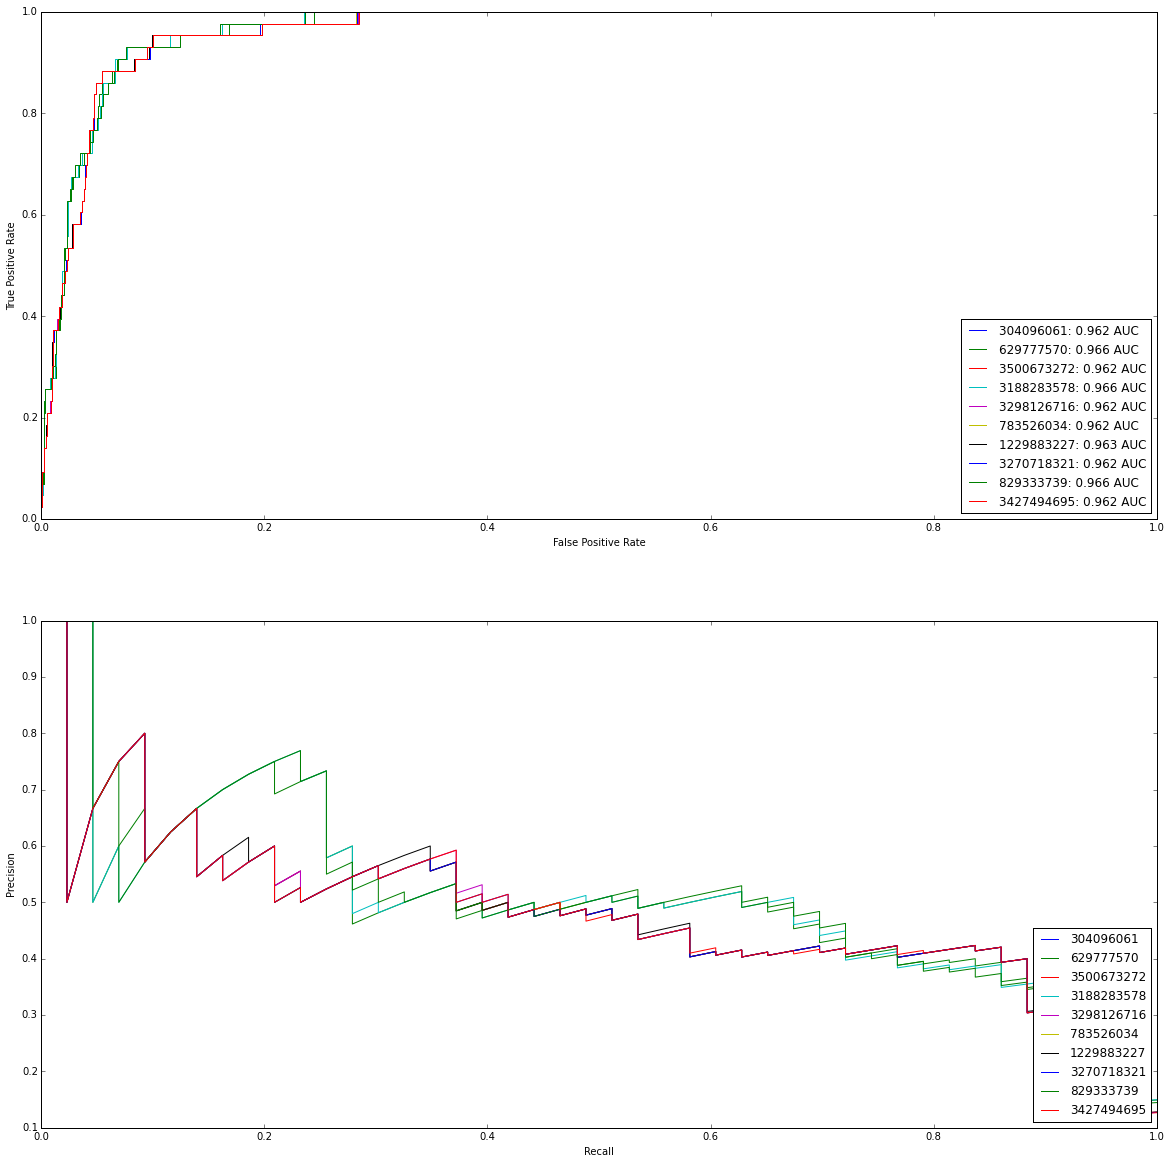

Warning, insufficient items to sample, returning all
Warning, inufficient items to sample, returning fewer
Warning, inufficient items to sample, returning 113468
Warning, insufficient items to sample, returning all
Warning, inufficient items to sample, returning fewer
Warning, inufficient items to sample, returning 186962
Warning, insufficient items to sample, returning all
Warning, inufficient items to sample, returning fewer
Warning, insufficient items to sample, returning all
Warning, inufficient items to sample, returning 3058
Warning, inufficient items to sample, returning 2084
Warning, insufficient items to sample, returning all
Warning, inufficient items to sample, returning fewer
Warning, inufficient items to sample, returning 113468
Warning, insufficient items to sample, returning all
Warning, inufficient items to sample, returning fewer
Warning, inufficient items to sample, returning 186962
Warning, insufficient items to sample, returning all
Warning, inufficient items to sam

|Model|Recall|Precision|F1-Score|
|-----|------|---------|--------|
|304096061|0.93|0.94|0.93|
|629777570|0.93|0.94|0.93|
|3500673272|0.93|0.94|0.93|
|3188283578|0.93|0.94|0.93|
|3298126716|0.93|0.94|0.93|
|783526034|0.93|0.94|0.93|
|1229883227|0.93|0.94|0.93|
|3270718321|0.93|0.94|0.93|
|829333739|0.93|0.94|0.93|
|3427494695|0.93|0.94|0.93|

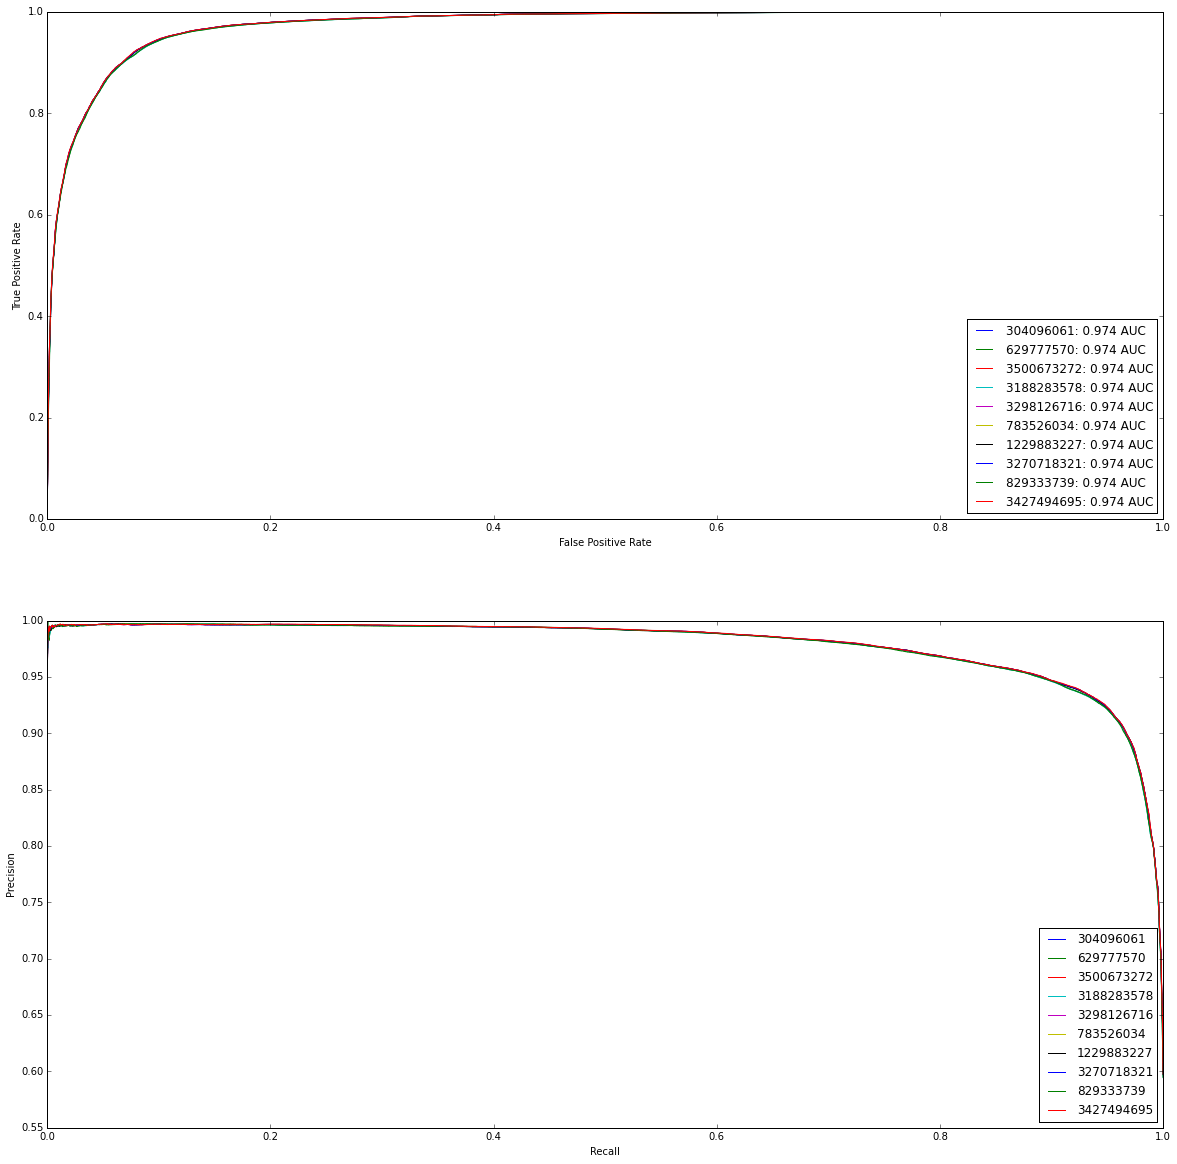

Warning, insufficient items to sample, returning all
Warning, inufficient items to sample, returning fewer
Warning, inufficient items to sample, returning 113468
Warning, insufficient items to sample, returning all
Warning, inufficient items to sample, returning fewer
Warning, inufficient items to sample, returning 186962
Warning, insufficient items to sample, returning all
Warning, inufficient items to sample, returning fewer
Warning, insufficient items to sample, returning all
Warning, inufficient items to sample, returning 3058
Warning, inufficient items to sample, returning 2084
Warning, insufficient items to sample, returning all
Warning, inufficient items to sample, returning fewer
Warning, inufficient items to sample, returning 113468
Warning, insufficient items to sample, returning all
Warning, inufficient items to sample, returning fewer
Warning, inufficient items to sample, returning 186962
Warning, insufficient items to sample, returning all
Warning, inufficient items to sam

|Model|Recall|Precision|F1-Score|
|-----|------|---------|--------|
|304096061|0.96|0.94|0.95|
|629777570|0.97|0.94|0.95|
|3500673272|0.96|0.94|0.95|
|3188283578|0.97|0.94|0.95|
|3298126716|0.96|0.94|0.95|
|783526034|0.96|0.94|0.95|
|1229883227|0.96|0.94|0.95|
|3270718321|0.96|0.94|0.95|
|829333739|0.96|0.94|0.95|
|3427494695|0.96|0.94|0.95|

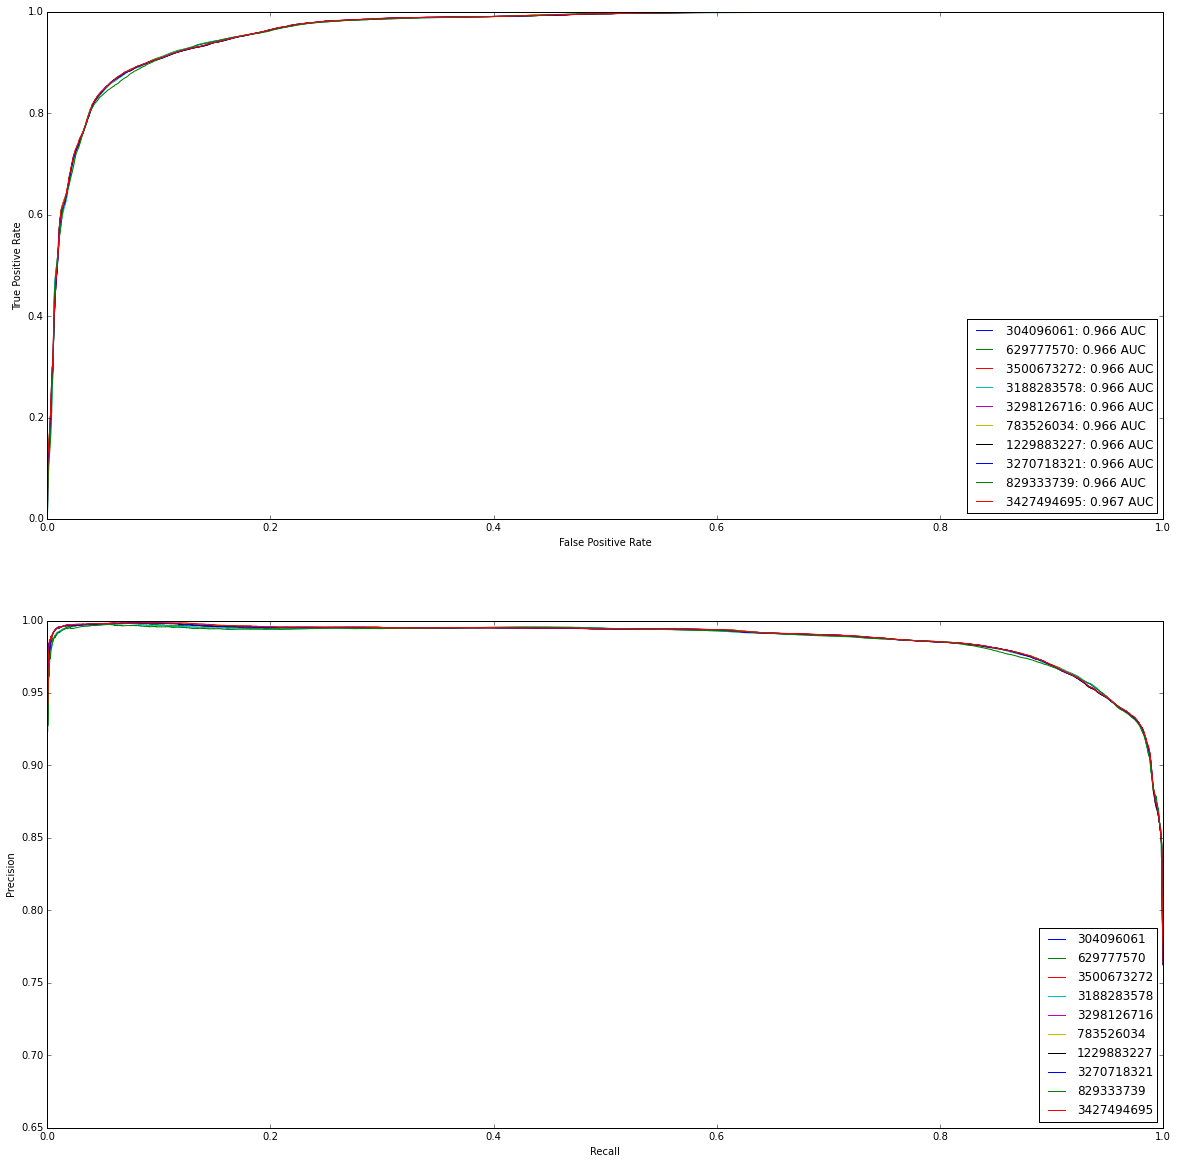

In [6]:
for gear in ['purse_seine', 'trawler', 'longliner']:
    X_test = test_data[gear]

    display(HTML("<h2>{}</h2>".format(gear.replace('_', ' ').title())))
        
    predictions = []
    trained_models = []
    for seed in get_seeds(N_SEEDS):
        mdl = make_model()
        
        train_data, test_data = load_data(seed)
        
        train_model_on_data(mdl, train_data[gear])
        
        trained_models.append((seed, mdl))
        
        predictions.append((seed, (mdl.predict_proba(X_test)[:,1] > 0.5), X_test['classification'] > 0.5))

    lines = ["|Model|Recall|Precision|F1-Score|",
         "|-----|------|---------|--------|"]
    for name, pred, actual in predictions:
        lines.append("|{}|{:.2f}|{:.2f}|{:.2f}|".format(name, 
                                            metrics.recall_score(actual, pred),
                                            metrics.precision_score(actual, pred), 
                                            metrics.f1_score(actual, pred)))

    display(Markdown('\n'.join(lines)))

    compare_models(trained_models, X_test)
    
    display(HTML("<hr/>"))

At first glance this looks impressive, but in retrospect the 
new code for dividing up up MMSI evenly no longer allow much randomness.
So this may not mean as much as I originally thought it would.